# English Wikipedia page views, 2008 - 2017

For this assignment, your job is to analyze traffic on English Wikipedia over time, and then document your process and the resulting dataset and visualization according to best practices for open research that were outlined for you in class.

### Example API request
You can use this example API request as a starting point for building your API queries. Note that the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) has slightly different schema than the [pageview API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) shown here.

This sample API request would get you all pageviews by web crawlers on the mobile website for English Wikipedia during the month of September, 2017.

### Import necessary libraries that will be used

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from datetime import datetime

%matplotlib inline

## Step 1: Data acquisition

In [2]:
# since we will be performing api calls at least five times, we will functionalize it
def data_acquisition(api_endpoint, access):

    '''
    call the wikimedia api and return a json format data set
    :param api_endpoint: legacy (pagecounts)
                         current (pageviews)
    :param access: legacy (all-sites, desktop-site, mobile-site)
                   current (desktop, mobile-app, mobile-web)
    '''
    
    # define the parameters for the api call (params listed below are universal across all api calls)
    params = {'project' : 'en.wikipedia.org',
                'agent' : 'user',
                'granularity' : 'monthly',
                'start' : '2008070100',
                'end' : '2017100100'
                }

    # check api_endpoint variable entered is valid for pagecounts
    if api_endpoint == 'pagecounts':
        endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
        params['access-site'] = access
        
        # check access variable entered is valid for pagecounts, print error otherwise
        if access != 'all-sites' and access != 'desktop-site' and access != 'mobile-site':
            print('error: invalid access (all-sites, desktop-site, mobile-site)')
        else:
            pass
    
    # check api_endpoint variable entered is valid for pageviews
    elif api_endpoint == 'pageviews':
        endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
        params['access'] = access
        
        # check access variable entered is valid for pageviews, print error otherwise
        if access != 'desktop' and access != 'mobile-app' and access != 'mobile-web':
            print('error: invalid access (desktop, mobile-app, mobile-web)')
        else:
            pass
    
    # print error message if invalid api_endpoint variable
    else:
        print('error: invalid api_endpoint (pagecounts, pageviews)')
    
#     headers={'User-Agent' : 'https://github.com/drjordy66', 'From' : 'drjordan@uw.edu'}
    
    api_call = requests.get(endpoint.format(**params))
    
    return api_call.json()


### Run the above function to call the API

In [3]:
response_pageview_desktop = data_acquisition('pageviews', 'desktop')
response_pageview_mobileweb = data_acquisition('pageviews', 'mobile-web')
response_pageview_mobileapp = data_acquisition('pageviews', 'mobile-app')
response_pagecount_all = data_acquisition('pagecounts', 'all-sites') # While this may be the simpler method, it is not in the instructions
response_pagecount_desktop = data_acquisition('pagecounts', 'desktop-site')
response_pagecount_mobile = data_acquisition('pagecounts', 'mobile-site')

### Export the API raw data files

In [4]:
json.dump(response_pageview_desktop, open('pageviews_desktop_' + response_pageview_desktop['items'][0]['timestamp'][:-4] + '-' + response_pageview_desktop['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)
json.dump(response_pageview_mobileweb, open('pageviews_mobile-web_' + response_pageview_mobileweb['items'][0]['timestamp'][:-4] + '-' + response_pageview_mobileweb['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)
json.dump(response_pageview_mobileapp, open('pageviews_mobile-app_' + response_pageview_mobileapp['items'][0]['timestamp'][:-4] + '-' + response_pageview_mobileapp['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)
# json.dump(response_pagecount_all, open('pagecounts_all-sites_' + response_pagecount_all['items'][0]['timestamp'][:-4] + '-' + response_pagecount_all['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)
json.dump(response_pagecount_desktop, open('pagecounts_desktop-site_' + response_pagecount_desktop['items'][0]['timestamp'][:-4] + '-' + response_pagecount_desktop['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)
json.dump(response_pagecount_mobile, open('pagecounts_mobile-site_' + response_pagecount_mobile['items'][0]['timestamp'][:-4] + '-' + response_pagecount_mobile['items'][-1]['timestamp'][:-4] + '.json', 'w'), indent=4)

## Step 2: Data processing

In [5]:
def get_views(api_response):
    
    '''
    strip all views from an api response
    '''
    
    temp_list = []
    for i in api_response['items']:
            temp_list.append([i['timestamp'], i['views']])
    
    return np.array(temp_list)

def get_count(api_response):
    
    '''
    strip all views from an api response
    '''
    
    temp_list = []
    for i in api_response['items']:
            temp_list.append([i['timestamp'], i['count']])
    
    return np.array(temp_list)

def lookup_val(api_views, date):
    
    '''
    find row index against all dates and create views respective column
    '''
    
    if i in list(api_views[:,0]):
        row_idx = list(api_views[:,0]).index(date)
        row_val = int(api_views[:,1][row_idx])
    else:
        row_val = 0
        
    return row_val


### Run the above functions to get all of the views/counts for both the legacy and current API

In [6]:
# strip all dates and views/count from api responses
pageview_desktop_views = get_views(response_pageview_desktop)
pageview_mobileweb_views = get_views(response_pageview_mobileweb)
pageview_mobileapp_views = get_views(response_pageview_mobileapp)
pagecount_desktop_views = get_count(response_pagecount_desktop)
pagecount_mobile_views = get_count(response_pagecount_mobile)

# combine all data into one array
all_dates_views = np.concatenate((pageview_desktop_views,
                                  pageview_mobileweb_views,
                                  pageview_mobileapp_views,
                                  pagecount_desktop_views,
                                  pagecount_mobile_views))

# strip only dates, remove duplicates, sort
all_dates = sorted(list(set(all_dates_views[:, 0])))

# parse into years and months
year_col = [all_dates[i][:-6] for i in range(len(all_dates))]
month_col = [all_dates[i][4:6] for i in range(len(all_dates))]

# initialize lists for columns of csv file
pageview_desktop_views_col = []
pageview_mobileweb_views_col = []
pageview_mobileapp_views_col = []
pagecount_desktop_views_col = []
pagecount_mobile_views_col = []

# loop through all of the dates and lookup respective values from each api response
for i in all_dates:
    pageview_desktop_views_col.append(lookup_val(pageview_desktop_views, i))
    pageview_mobileweb_views_col.append(lookup_val(pageview_mobileweb_views, i))
    pageview_mobileapp_views_col.append(lookup_val(pageview_mobileapp_views, i))
    pagecount_desktop_views_col.append(lookup_val(pagecount_desktop_views, i))
    pagecount_mobile_views_col.append(lookup_val(pagecount_mobile_views, i))

# aggregate the mobile views from pageviews and the "all views" from pageviews and pagecounts
pageview_mobile_views_col = [sum(i) for i in zip(pageview_mobileweb_views_col, pageview_mobileapp_views_col)]
pageview_all_views_col = [sum(i) for i in zip(pageview_desktop_views_col, pageview_mobile_views_col)]
pagecount_all_views_col = [sum(i) for i in zip(pagecount_desktop_views_col, pagecount_mobile_views_col)]


### Export data in single csv

In [7]:
# assign column data to a pandas dataframe
df = pd.DataFrame({'year': year_col,
                   'month': month_col,
                   'pagecount_all_views': pagecount_all_views_col,
                   'pagecount_desktop_views': pagecount_desktop_views_col,
                   'pagecount_mobile_views': pagecount_mobile_views_col,
                   'pageview_all_views': pageview_all_views_col,
                   'pageview_desktop_views': pageview_desktop_views_col,
                   'pageview_mobile_views': pageview_mobile_views_col})

# organize in correct column order
df = df[['year',
         'month',
         'pagecount_all_views',
         'pagecount_desktop_views',
         'pagecount_mobile_views',
         'pageview_all_views',
         'pageview_desktop_views',
         'pageview_mobile_views']]

# write the column data to csv
df.to_csv('en-wikipedia_traffic_200801-201709.csv', index=False)


## Step 3: Analysis

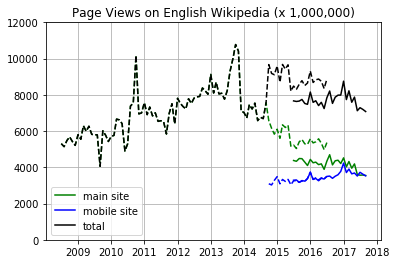

In [8]:
# convert dates to a datetime format for plotting
dates = np.array([datetime.strptime(list(df['year'])[i] + list(df['month'])[i], '%Y%m') for i in range(len(df))])

# plot the points, filtering on non-zero values in the column data
plt.plot(dates[np.array(df['pageview_desktop_views']) > 0],
         np.array(df['pageview_desktop_views'])[np.array(df['pageview_desktop_views']) > 0], 'g')
plt.plot(dates[np.array(df['pageview_mobile_views']) > 0],
         np.array(df['pageview_mobile_views'])[np.array(df['pageview_mobile_views']) > 0], 'b')
plt.plot(dates[np.array(df['pageview_all_views']) > 0],
         np.array(df['pageview_all_views'])[np.array(df['pageview_all_views']) > 0], 'k')
plt.plot(dates[np.array(df['pagecount_desktop_views']) > 0][:-1],
         np.array(df['pagecount_desktop_views'])[np.array(df['pagecount_desktop_views']) > 0][:-1], 'g--')
plt.plot(dates[np.array(df['pagecount_mobile_views']) > 0][:-1],
         np.array(df['pagecount_mobile_views'])[np.array(df['pagecount_mobile_views']) > 0][:-1], 'b--')
plt.plot(dates[np.array(df['pagecount_all_views']) > 0][:-1],
         np.array(df['pagecount_all_views'])[np.array(df['pagecount_all_views']) > 0][:-1], 'k--')

# add gridlines and scale (to match assignment), title, legend
plt.grid(True)
plt.ylim(0, 12e9)
plt.yticks([0, 2e9, 4e9, 6e9, 8e9, 10e9, 12e9], [0, 2000, 4000, 6000, 8000, 10000, 12000])
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.legend(['main site', 'mobile site', 'total'])


# old code...

In [ ]:
# endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# headers={'User-Agent' : 'https://github.com/drjordy66', 'From' : 'drjordan@uw.edu'}

# params = {'project' : 'en.wikipedia.org',
#             'access' : 'desktop',
#             'agent' : 'user',
#             'granularity' : 'monthly',
#             'start' : '2008070100',
#             'end' : '2017100100'
#             }
# api_call = requests.get(endpoint.format(**params))
# response_pageview_desktop = api_call.json()

# params['access'] = 'mobile-web'
# api_call = requests.get(endpoint.format(**params))
# response_pageview_mobileweb = api_call.json()

# params['access'] = 'mobile-app'
# api_call = requests.get(endpoint.format(**params))
# response_pageview_mobileapp = api_call.json()

# del params['access']
# endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
# params['access-site'] = 'all-sites'
# api_call = requests.get(endpoint.format(**params))
# response_pagecount_all = api_call.json()

# params['access-site'] = 'desktop-site'
# api_call = requests.get(endpoint.format(**params))
# response_pagecount_desktop = api_call.json()

# params['access-site'] = 'mobile-site'
# api_call = requests.get(endpoint.format(**params))
# response_pagecount_mobile = api_call.json()


In [ ]:
# pageview_desktop_dates = []
# pageview_desktop_views = []
# for i in response_pageview_desktop['items']:
#     pageview_desktop_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pageview_desktop_views.append(i['views'])

# pageview_mobileweb_dates = []
# pageview_mobileweb_views = []
# for i in response_pageview_mobileweb['items']:
#     pageview_mobileweb_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pageview_mobileweb_views.append(i['views'])

# pageview_mobileapp_dates = []
# pageview_mobileapp_views = []
# for i in response_pageview_mobileapp['items']:
#     pageview_mobileapp_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pageview_mobileapp_views.append(i['views'])

# pageview_mobile_dates = pageview_mobileweb_dates
# pageview_mobile_views = [pageview_mobileweb_views[i] + pageview_mobileapp_views[i] for i in range(len(pageview_mobileweb_views))]

# pageview_all_dates = pageview_desktop_dates
# pageview_all_views = [pageview_desktop_views[i] + pageview_mobile_views[i] for i in range(len(pageview_desktop_views))]

# pagecount_all_dates = []
# pagecount_all_views = []
# for i in response_pagecount_all['items']:
#     pagecount_all_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pagecount_all_views.append(i['count'])
    
# pagecount_desktop_dates = []
# pagecount_desktop_views = []
# for i in response_pagecount_desktop['items']:
#     pagecount_desktop_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pagecount_desktop_views.append(i['count'])

# pagecount_mobile_dates = []
# pagecount_mobile_views = []
# for i in response_pagecount_mobile['items']:
#     pagecount_mobile_dates.append(datetime.strptime(i['timestamp'][:-4], '%Y%m'))
#     pagecount_mobile_views.append(i['count'])

# pagecount_all_dates2 = pagecount_desktop_dates
# pagecount_all_views2 = []
# for i in range(len(pagecount_desktop_views)):
#     desktopmobile = 'False'
#     for j in range(len(pagecount_mobile_views)):
#         if pagecount_desktop_dates[i] == pagecount_mobile_dates[j]:
#             pagecount_all_views2.append(pagecount_desktop_views[i] + pagecount_mobile_views[j])
#             desktopmobile = 'True'
#             break
#         else:
#             pass
#     if desktopmobile == 'False':
#         pagecount_all_views2.append(pagecount_desktop_views[i])
#     else:
#         pass


In [ ]:
# plt.plot(pageview_desktop_dates, pageview_desktop_views, 'g')
# plt.plot(pageview_mobile_dates, pageview_mobile_views, 'b')
# plt.plot(pageview_all_dates, pageview_all_views, 'k')
# plt.plot(pagecount_desktop_dates[:-1], pagecount_desktop_views[:-1], 'g--')
# plt.plot(pagecount_mobile_dates[:-1], pagecount_mobile_views[:-1], 'b--')
# plt.plot(pagecount_all_dates[:-1], pagecount_all_views[:-1], 'k--')
# plt.grid(True)
# plt.ylim(0, 12e9)
# plt.yticks([0, 2e9, 4e9, 6e9, 8e9, 10e9, 12e9], [0, 2000, 4000, 6000, 8000, 10000, 12000])
# plt.title('Page Views on English Wikipedia (x 1,000,000)')
# plt.legend(['main site', 'mobile site', 'total'])
